# Analyze continuous assay prediction

Here we compare the MTT and LDH regression model performance across representations, and to the random / cell count baselines.

In [19]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [10]:
res_dir = "../../1_snakemake/outputs"

dino_pred = f"{res_dir}/dino/mad_featselect/classifier_results/axiom_continuous_predictions.parquet"
cpcnn_pred = f"{res_dir}/cpcnn/mad_featselect/classifier_results/axiom_continuous_predictions.parquet"
cellprofiler_pred = f"{res_dir}/cellprofiler/mad_featselect/classifier_results/axiom_continuous_predictions.parquet"

dino = pl.read_parquet(dino_pred).with_columns(
    pl.lit("DINO").alias("Representation"),
)
cpcnn = pl.read_parquet(cpcnn_pred).with_columns(
    pl.lit("CP-CNN").alias("Representation"),
)
cellprofiler = pl.read_parquet(cellprofiler_pred).with_columns(
    pl.lit("CellProfiler").alias("Representation"),
)

preds = pl.concat([
    dino, cpcnn, cellprofiler
], how="vertical")

# Append cell count
cc = pl.read_parquet(f"{res_dir}/dino/mad_featselect/profiles/mad_featselect.parquet").select(
    ["Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"]
)

preds = preds.join(cc, on=["Metadata_Plate", "Metadata_Well"])

In [90]:
dino_res = f"{res_dir}/dino/mad_featselect/classifier_results/axiom_continuous_metrics.parquet"
cpcnn_res = f"{res_dir}/cpcnn/mad_featselect/classifier_results/axiom_continuous_metrics.parquet"
cellprofiler_res = f"{res_dir}/cellprofiler/mad_featselect/classifier_results/axiom_continuous_metrics.parquet"

dino = pl.read_parquet(dino_res).with_columns(
    pl.when(pl.col("Model_type") == "Morphology").then(pl.lit("Morphology_DINO")).otherwise(pl.col("Model_type")).alias("Model_type")
).filter(pl.col("Model_type") == "Morphology_DINO")
cpcnn = pl.read_parquet(cpcnn_res).with_columns(
    pl.when(pl.col("Model_type") == "Morphology").then(pl.lit("Morphology_CPCNN")).otherwise(pl.col("Model_type")).alias("Model_type")
).filter(pl.col("Model_type") == "Morphology_CPCNN")
cellprofiler = pl.read_parquet(cellprofiler_res).with_columns(
    pl.when(pl.col("Model_type") == "Morphology").then(pl.lit("Morphology_CellProfiler")).otherwise(pl.col("Model_type")).alias("Model_type")
)

res = pl.concat([
    dino, cpcnn, cellprofiler
], how="vertical").drop("Variable_Name").to_pandas()

In [79]:
# Compute metrics for replicates
dat = pl.read_parquet(f"{res_dir}/dino/mad_featselect/profiles/mad_featselect.parquet").select(
    ["Metadata_Compound", "Metadata_Log10Conc", "Metadata_mtt_ridge_norm", "Metadata_ldh_ridge_norm"]
).filter(
    pl.col("Metadata_Compound") != "DMSO"
)

dat = dat.with_columns(
    pl.arange(0, pl.len()).over(["Metadata_Compound", "Metadata_Log10Conc"]).alias("Replicate_number")
)
dat = dat.with_columns((pl.col("Replicate_number") + 1).alias("Replicate_number"))

dat = dat.pivot(
    index=["Metadata_Compound", "Metadata_Log10Conc"],
    on="Replicate_number",
    values=["Metadata_mtt_ridge_norm", "Metadata_ldh_ridge_norm"],
    aggregate_function="first"
)
dat = dat.select([
    "Metadata_Compound", "Metadata_Log10Conc", "Metadata_mtt_ridge_norm_1", "Metadata_mtt_ridge_norm_2", 
    "Metadata_ldh_ridge_norm_1", "Metadata_ldh_ridge_norm_2"
]).to_pandas()

In [92]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from tqdm import tqdm
import numpy as np
import pandas as pd

groups = dat["Metadata_Compound"]
gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

results = []
for split_idx, (train_idx, test_idx) in tqdm(enumerate(gss.split(dat, groups=groups)), desc=f"Processing"):
    split_dat = dat.iloc[test_idx]

    mtt_split = split_dat[["Metadata_mtt_ridge_norm_1", "Metadata_mtt_ridge_norm_2"]].dropna()
    mtt_1 = mtt_split["Metadata_mtt_ridge_norm_1"]
    mtt_2 = mtt_split["Metadata_mtt_ridge_norm_2"]

    ldh_split = split_dat[["Metadata_ldh_ridge_norm_1", "Metadata_ldh_ridge_norm_2"]].dropna()
    ldh_1 = ldh_split["Metadata_ldh_ridge_norm_1"]
    ldh_2 = ldh_split["Metadata_ldh_ridge_norm_2"]

    # Calculate performance for ldh
    mse = mean_squared_error(ldh_1, ldh_2)
    r2 = r2_score(ldh_1, ldh_2)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(ldh_1, ldh_2)
    results.append(("Metadata_ldh_ridge_norm", split_idx, r2, rmse, mae))

    # Calculate performance for mtt
    mse = mean_squared_error(mtt_1, mtt_2)
    r2 = r2_score(mtt_1, mtt_2)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(mtt_1, mtt_2)
    results.append(("Metadata_mtt_ridge_norm", split_idx, r2, rmse, mae))

rep_results = pd.DataFrame(results, columns=["Variable", "Split", "R²", "RMSE", "MAE"])
rep_results["Model_type"] = "Replicates"

res = pd.concat([res, rep_results], axis=0, ignore_index=True)



Processing: 10it [00:00, 102.03it/s]


In [27]:
# Define a function to plot violin and swarm plots grouped by variable types
def violin_swarm_plot_by_variable(df, variable_type, metric):

    df = df[df['Variable'].str.contains(variable_type)]
    
    plt.figure(figsize=(5, 5), dpi=100)
    sns.violinplot(data=df, x="Model_type", y=metric, inner="box", palette="Accent", hue="Model_type", legend=False)
    sns.swarmplot(data=df, x="Model_type", y=metric, color="k", alpha=1, s=3)
    
    # Set custom labels
    plt.xlabel("Model type")
    plt.ylabel(metric)
    #plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=90)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [54]:
from plotnine import ggplot, aes, theme_classic, geom_boxplot, geom_sina, labs, theme, element_text, scale_x_discrete, geom_jitter

def boxplot_jitterplot(df, variable_type, metric):
    df_filt = df[df['Variable'].str.contains(variable_type)]

    plot = (
        ggplot(df_filt, aes(x='Model_type', y=metric)) 
        + geom_boxplot(color="red", alpha=0.25, size=1, outlier_alpha=0)
        + geom_jitter(color="black") 
        + labs(x='Model type', y=metric) 
        + theme_classic()
        + theme(axis_text_x=element_text(angle=45, hjust=1))
        + scale_x_discrete(labels={
            "Morphology_DINO": "Morphology (DINO)", 
            "Morphology_CPCNN": "Morphology (CP-CNN)", 
            "Morphology_CellProfiler": "Morphology (CellProfiler)", 
            "Baseline": "Baseline", 
            "Mean_predictor": "Mean predictor",
        })
    )
    plot.show()

Metadata_ldh_ridge_norm
R²


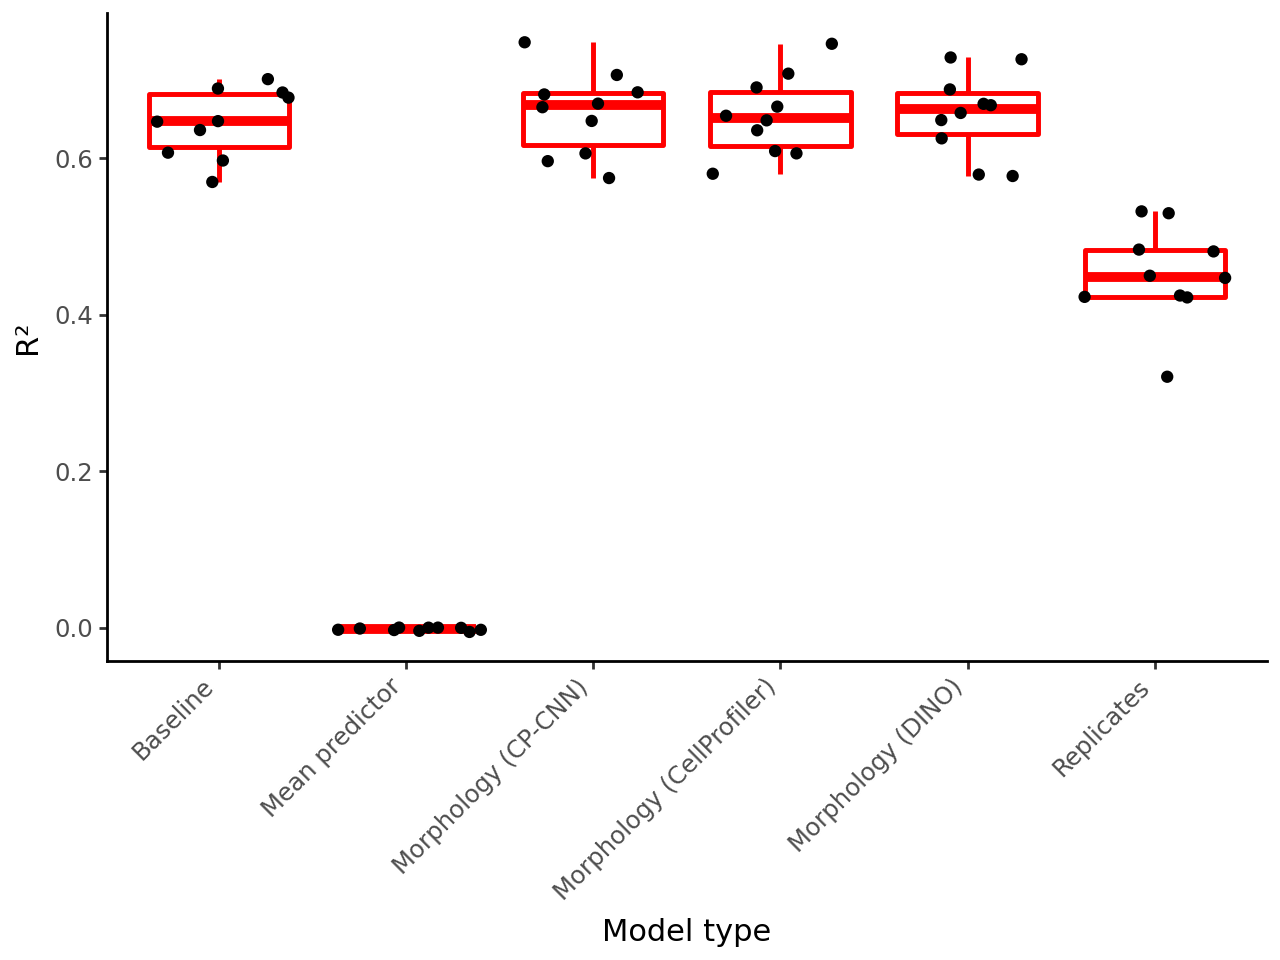

Metadata_ldh_ridge_norm
RMSE


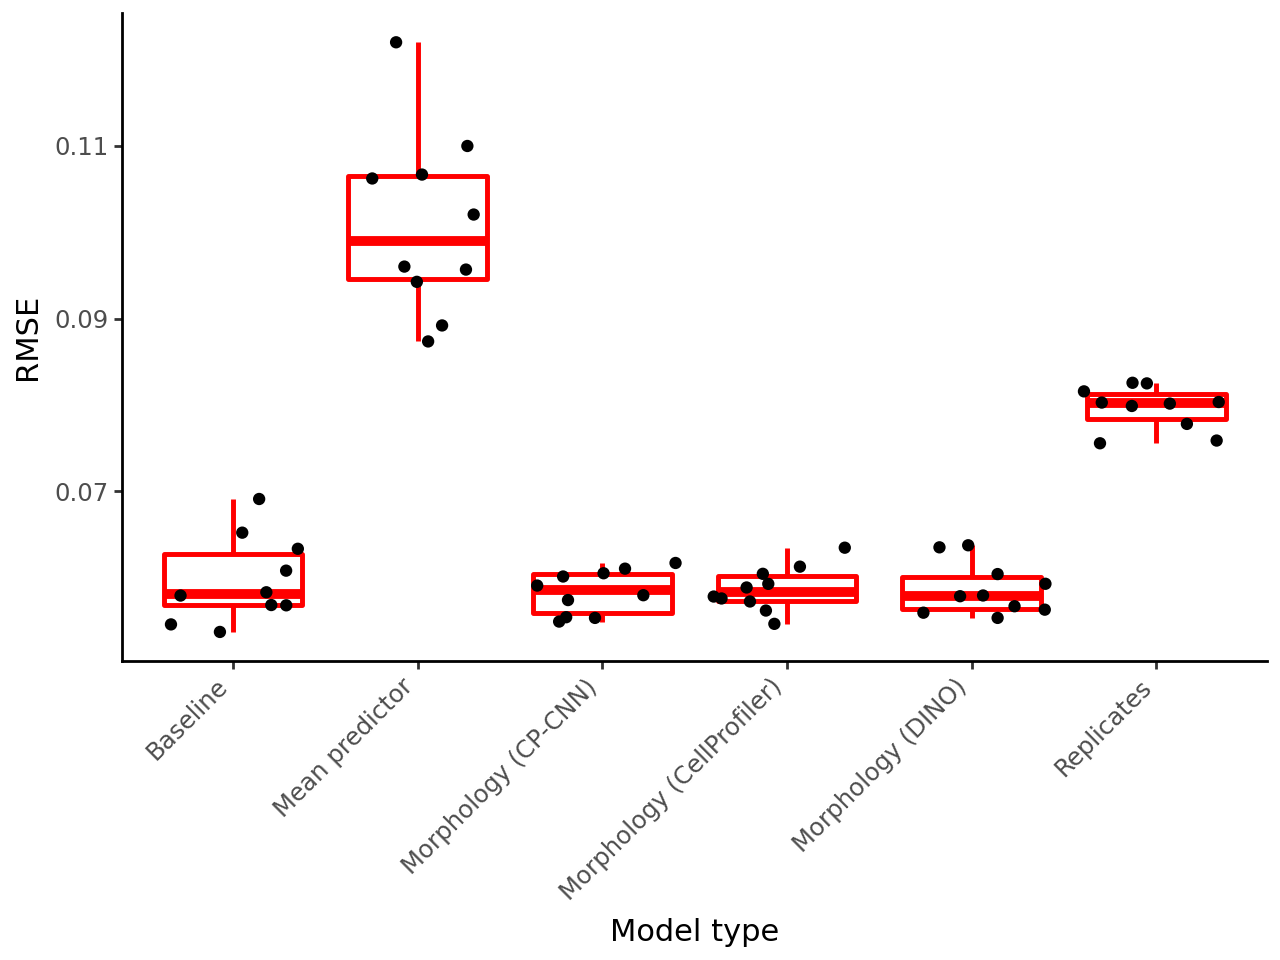

Metadata_ldh_ridge_norm
MAE


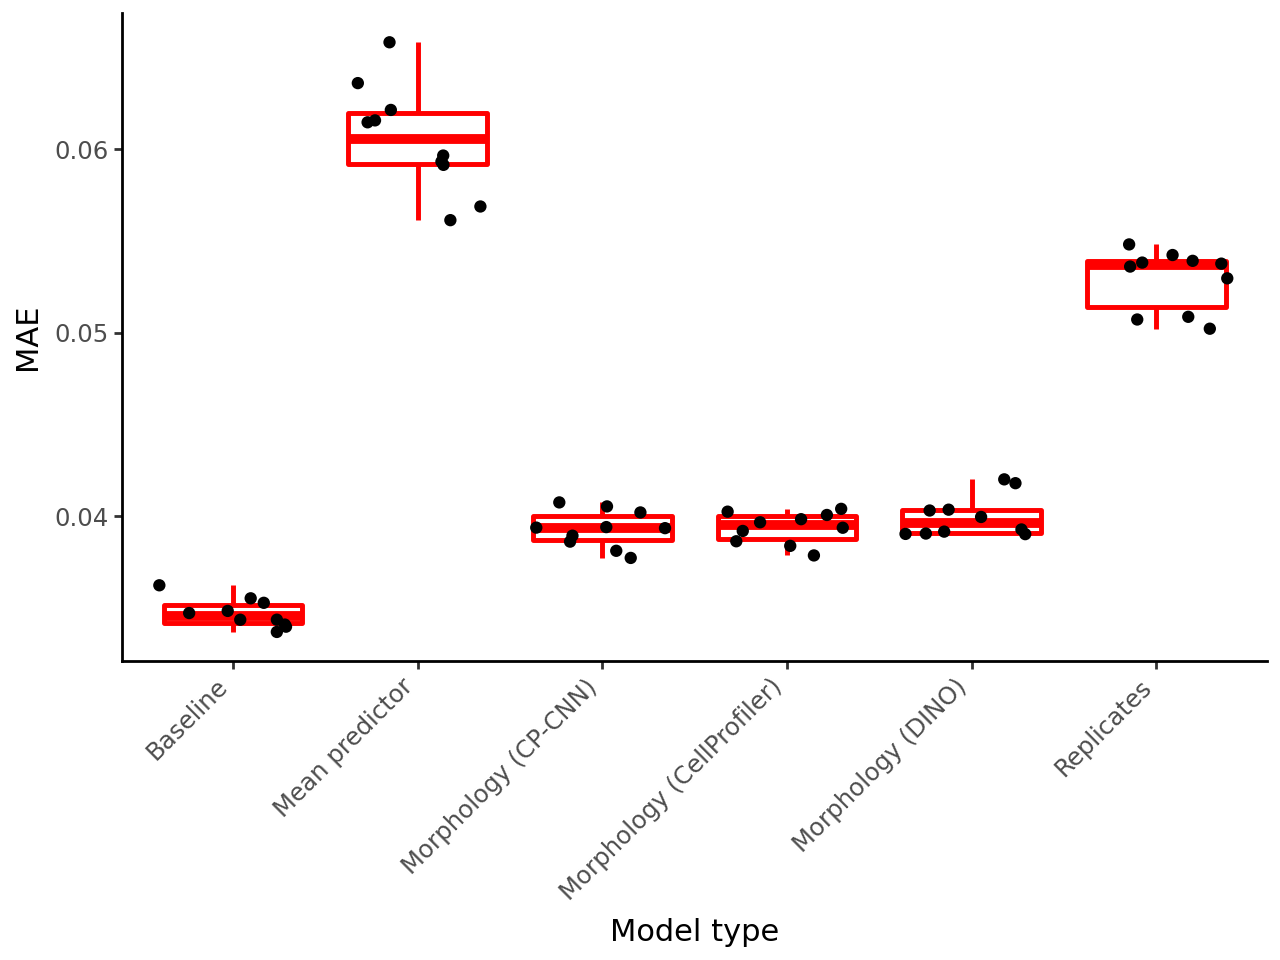

Metadata_mtt_ridge_norm
R²


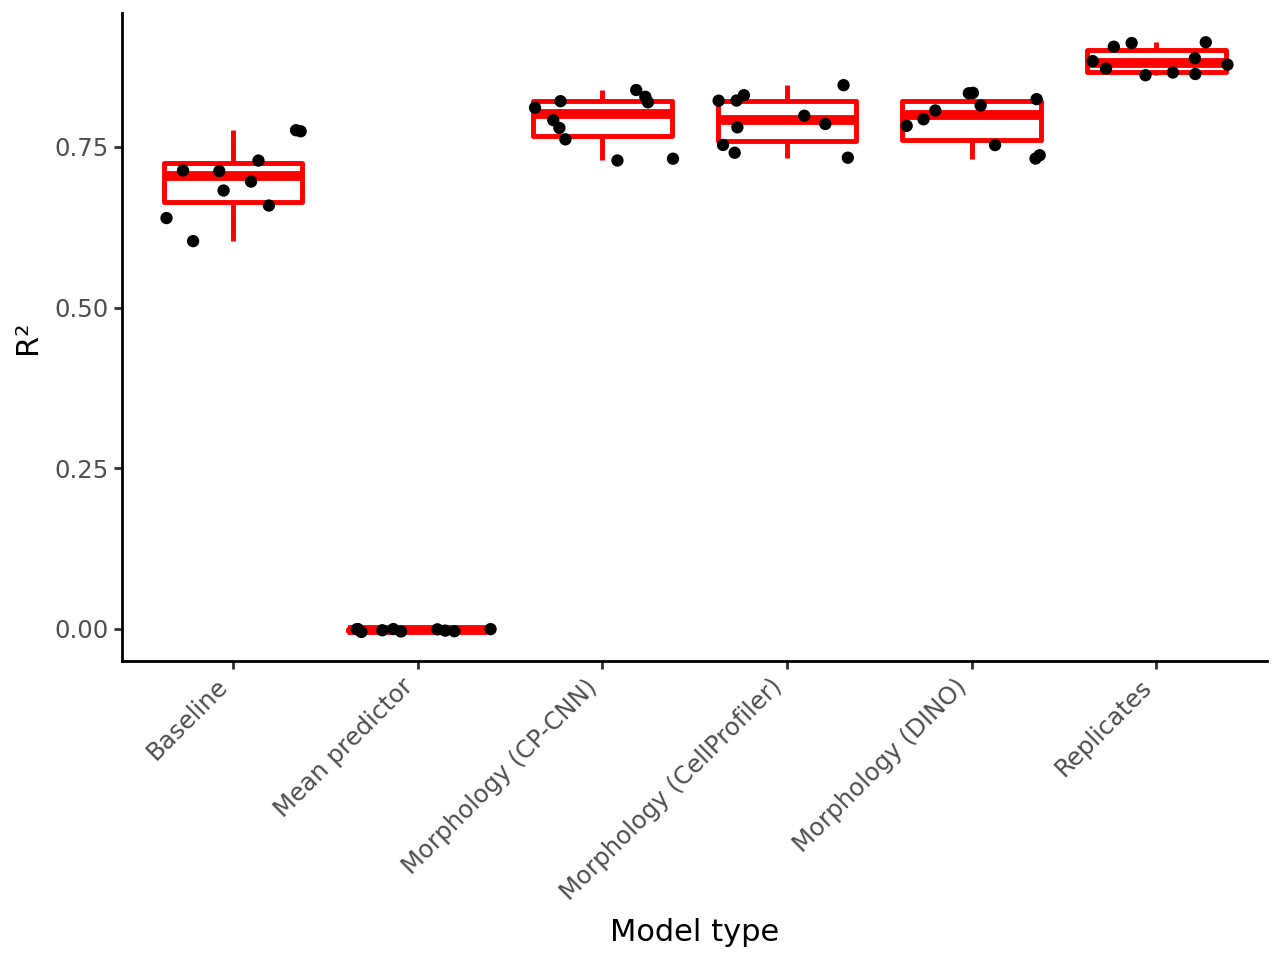

Metadata_mtt_ridge_norm
RMSE


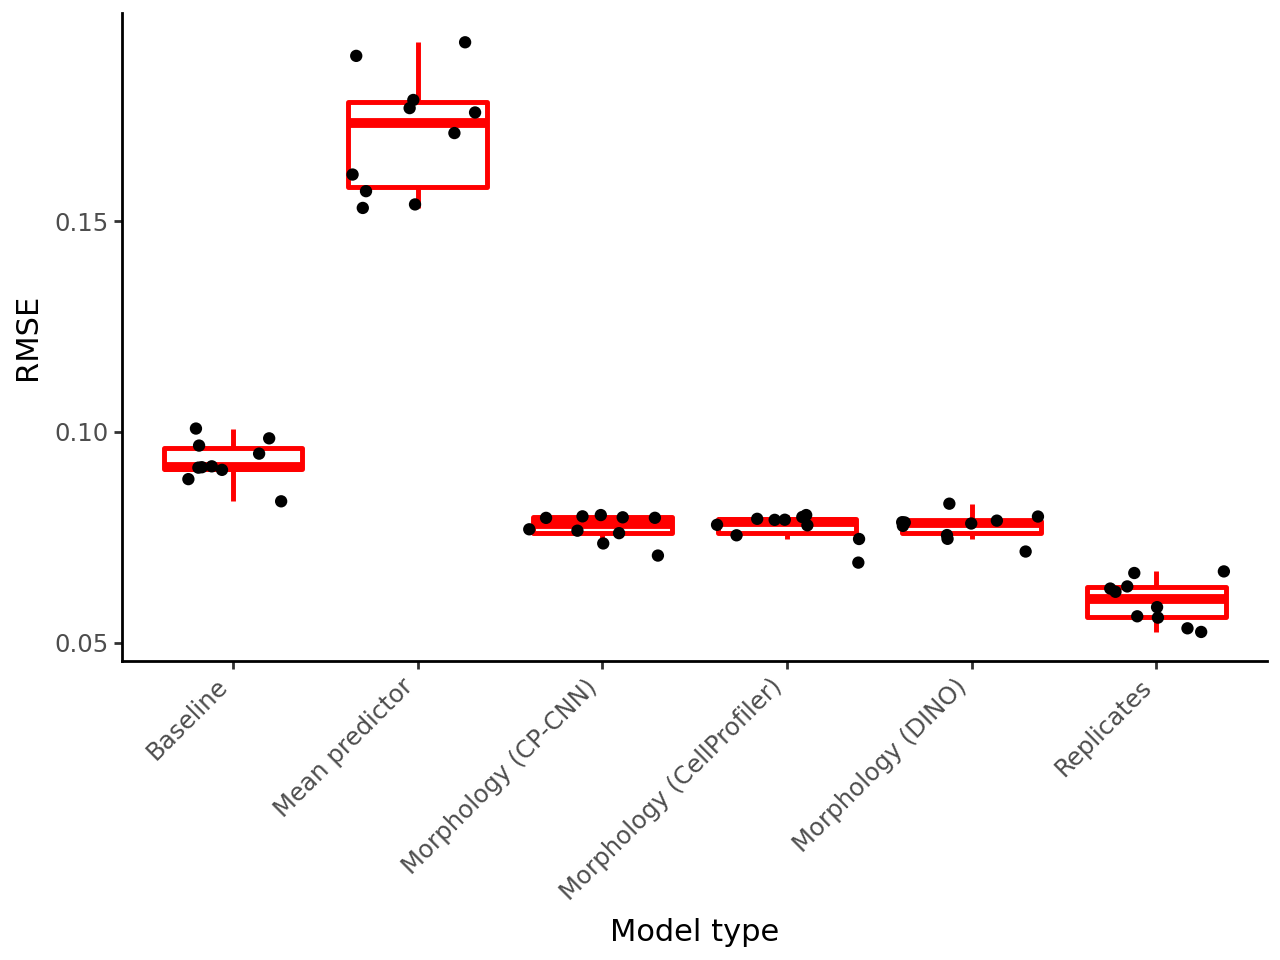

Metadata_mtt_ridge_norm
MAE


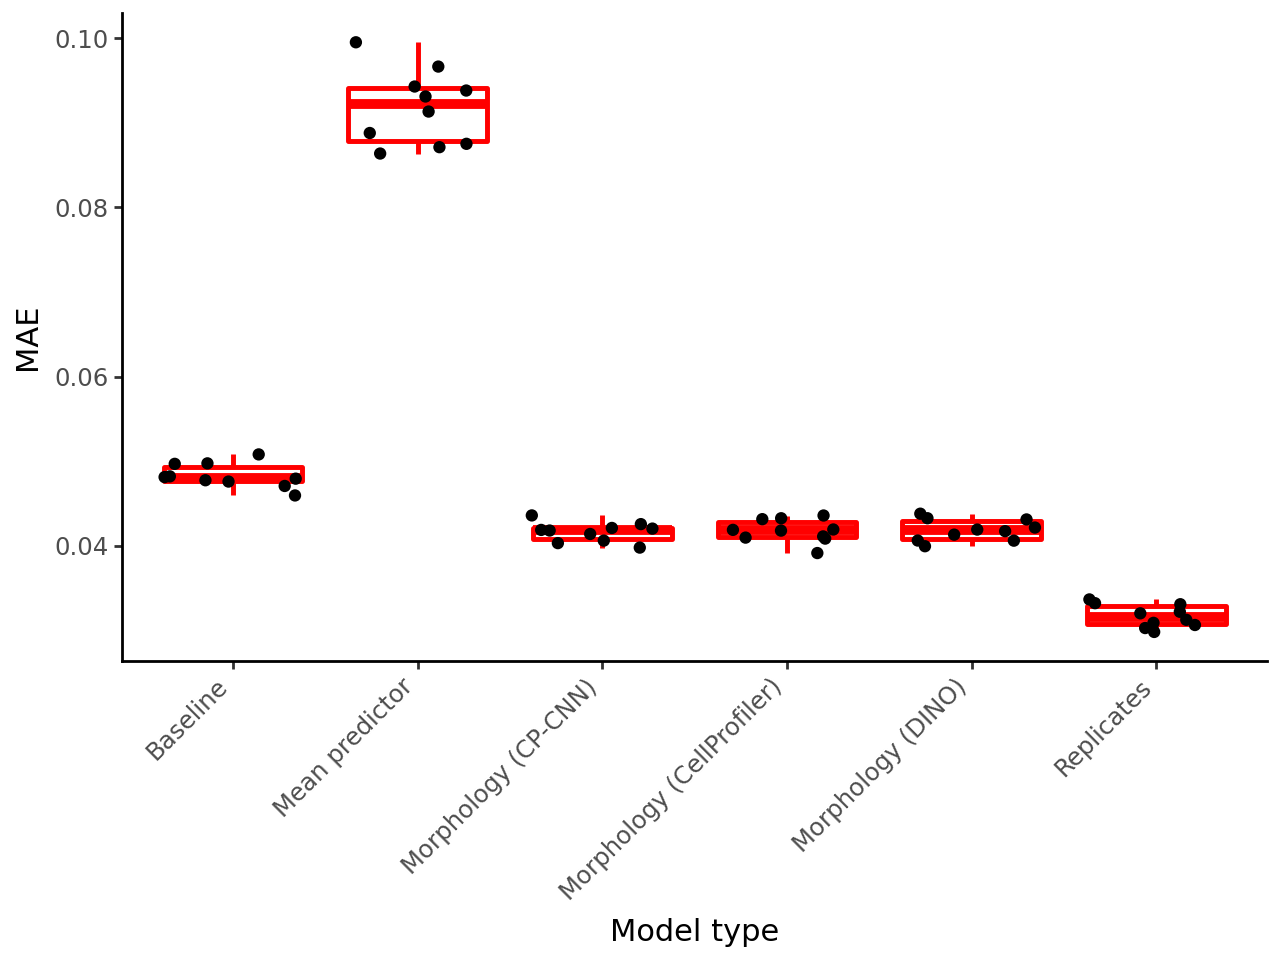

In [94]:
metrics = ["R²", "RMSE", "MAE"]
variable_types = ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm']

for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        print(metric)
        boxplot_jitterplot(res, variable_type, metric)

In [97]:
summary_df = res.groupby(["Variable", "Model_type"]).agg({
    "R²": ["mean", "std"],
    "RMSE": ["mean", "std"],
    "MAE": ["mean", "std"]
}).reset_index()

# Flatten the column names for readability
summary_df.columns = ["_".join(col).strip("_") for col in summary_df.columns]

def round_to_2_sigfigs(x):
    if isinstance(x, (int, float)) and not np.isnan(x):  # Ensure the value is numeric
        return float(f"{x:.2g}")
    return x  # Return non-numeric values unchanged

summary_df= summary_df.applymap(round_to_2_sigfigs)

# Display the result
print(summary_df)

                   Variable               Model_type  R²_mean  R²_std  \
0   Metadata_ldh_ridge_norm                 Baseline   0.6500  0.0440   
1   Metadata_ldh_ridge_norm           Mean_predictor  -0.0020  0.0020   
2   Metadata_ldh_ridge_norm         Morphology_CPCNN   0.6600  0.0530   
3   Metadata_ldh_ridge_norm  Morphology_CellProfiler   0.6500  0.0510   
4   Metadata_ldh_ridge_norm          Morphology_DINO   0.6600  0.0520   
5   Metadata_ldh_ridge_norm               Replicates   0.4500  0.0620   
6   Metadata_mtt_ridge_norm                 Baseline   0.7000  0.0550   
7   Metadata_mtt_ridge_norm           Mean_predictor  -0.0019  0.0017   
8   Metadata_mtt_ridge_norm         Morphology_CPCNN   0.7900  0.0400   
9   Metadata_mtt_ridge_norm  Morphology_CellProfiler   0.7900  0.0390   
10  Metadata_mtt_ridge_norm          Morphology_DINO   0.7900  0.0390   
11  Metadata_mtt_ridge_norm               Replicates   0.8800  0.0200   

    RMSE_mean  RMSE_std  MAE_mean  MAE_std  
0    

/tmp/ipykernel_44441/1642972571.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
